In [1]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

fatal: destination path 'pytorch-CycleGAN-and-pix2pix' already exists and is not an empty directory.


In [14]:
!pip install -r /content/pytorch-CycleGAN-and-pix2pix/requirements.txt

     |████████████████████████████████| 686kB 6.7MB/s 
     |████████████████████████████████| 204kB 19.2MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655251 sha256=7d7ffa29c2f8f53c7c867431667a2311826ee6a5d342faf71abd03ca26cefa37
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5711 sha256=ef09464b757b6e57d7cca49f212a625ba7e12c69a1a320f849bc9c5194460788
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


In [2]:
!bash /content/pytorch-CycleGAN-and-pix2pix/scripts/download_cyclegan_model.sh style_vangogh

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [style_vangogh]
for details.

--2020-11-07 07:40:41--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/style_vangogh.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/style_vangogh_pretrained/latest_net_G.pth’

./checkpoints/style 100%[===================>]  43.46M  40.9MB/s    in 1.1s    

2020-11-07 07:40:42 (40.9 MB/s) - ‘./checkpoints/style_vangogh_pretrained/latest_net_G.pth’ saved [45575747/45575747]



In [18]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import random
import numpy as np
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
from abc import ABC, abstractmethod
from torch.nn import init
from matplotlib import pyplot as plt
import time
#load size 256
#!python /content/pytorch-CycleGAN-and-pix2pix/test.py --dataroot /content/image --name style_vangogh_pretrained --model test --no_dropout --results_dir /content/result
#multi-gpu가능 https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/f13aab8148bd5f15b9eb47b690496df8dadbab0c/models/networks.py#L101

#MODEL

In [2]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


In [3]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


#Function

In [4]:
def init_func(m):  # define the initialization function
        init_type='normal'
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)
#generator=generator.apply(init_func)

In [5]:
def patch_instance_norm_state_dict(state_dict, module, keys, i=0):
        """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))

            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))

        else:
            patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

        return state_dict

In [6]:
def get_transform( params=None, grayscale=False, method=Image.BICUBIC, convert=True):
    transform_list = []
    '''if grayscale:
        transform_list.append(transforms.Grayscale(1))'''
    
    osize = [256, 256]
    transform_list.append(transforms.Resize(osize, method))

    if params is None:
        transform_list.append(transforms.RandomCrop(256))
    else:
        transform_list.append(transforms.Lambda(lambda img: __crop(img, params['crop_pos'], 256)))

    if params is None:
        transform_list.append(transforms.RandomHorizontalFlip())
        '''elif params['flip']:
            transform_list.append(transforms.Lambda(lambda img: __flip(img, params['flip'])))'''

    transform_list += [transforms.ToTensor()]
    transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

In [7]:
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.
    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

#Generator

In [8]:
norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
generator=ResnetGenerator(input_nc=3,output_nc=3,ngf=64, norm_layer=norm_layer, use_dropout=False, n_blocks=9, padding_type='reflect')

In [9]:
state=torch.load('/content/checkpoints/style_vangogh_pretrained/latest_net_G.pth')
if hasattr(state, '_metadata'):
  del state._metadata

# patch InstanceNorm checkpoints prior to 0.4
for key in list(state.keys()):  # need to copy keys here because we mutate in loop
    patch_instance_norm_state_dict(state, generator, key.split('.'))

generator.load_state_dict(state)

<All keys matched successfully>

In [10]:
device = torch.device("cuda")
generator.to(device)

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

change the image url below

In [19]:
transform=get_transform()
A_img = Image.open('/content/image/gan_4.jpg').convert('RGB')
A = transform(A_img)
real = A.to(device)
start_time = time.time()
fake = generator(real.unsqueeze(0))
end_time = time.time()
print("WorkingTime: {} sec".format(end_time-start_time))

WorkingTime: 0.006769657135009766 sec


In [15]:
img=tensor2im(fake)

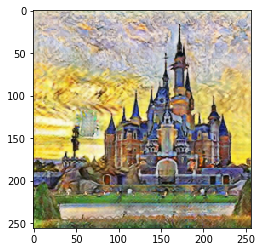

In [17]:
plt.imshow(img, interpolation='nearest')
plt.show()